In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import corner
import functions

In [2]:
# This is a useful bit of Jupyter notebook magic that makes
# it so that any changes to imported modules are automatically 
# reflected in your notebook without restarting your kernel
%load_ext autoreload
%autoreload 2

In [3]:
#Getting the data
data = pd.read_csv('/home/michael/Documents/Mcgill_Courses/PHYS 321/PHYS321-final-project/cristiano-ronaldo-stats.csv') # loading up the data retrieved from the websites
goalScored = data['pen-scored'].astype(float) # assigning them varaible names
goalDiff = data['score-diff'].astype(float)
saveRate = data['goal-keeper-success-rate'].astype(float)

#Global variables
numBetas = 300 #This is the number of betas we are testing


Lets find an MCMC plot of $P(Scoring)$ where $P(Scoring) = \frac{1}{1+e^{-\beta (save rate)}}$ $\newline$
This will be tackled in three steps:
1) Find a posterior distribution for $\beta$ so we know the range of values it takes
2) Use this posterior to run an MCMC that samples different values of $\beta$
3) Use these samples of $\beta$ to plot many different possible values of $P(Scoring)$

In [4]:
#The linear prior for beta between min and max_value
def prior(min_val, max_val): # Creating our prior function
    #x = np.linspace(min_val, max_val, numBetas)   
    #y = np.zeros_like(x)                         
    
    # set the y-values for the linear distribution
    #y[(x >= min_val) & (x <= max_val)] = 1 / (max_val - min_val)
    y = np.zeros(numBetas)
    y += 1/(max_val-min_val)
    return y

In [5]:
#The probabiltiy function for p(scoring) given the data and a value of beta
# def p(beta, data):
#     return 1/(1+np.exp(-beta*data))

#Define the likelihood function from wikipedia
def likelihood(betas,Data,Scored,log=True):
    
    
    l = []
    for b in betas:
        #Equation from wikipedia
        l.append(sum(Scored*np.log(functions.p(b,Data)) + (1-Scored)*np.log(1-functions.p(b,Data))))

    #Convert to numpy array
    li = np.array(l)

    if(log):
        return li
    else:
        return np.exp(li)

In [6]:
#Define the posterior and normalise
def post(betas,Data,Scored,minB,maxB):
    #posterior
    y = prior(minB,maxB)*likelihood(betas,Data,Scored,False)
    #normalise
    y = y / np.trapz(y,betas)
    return y

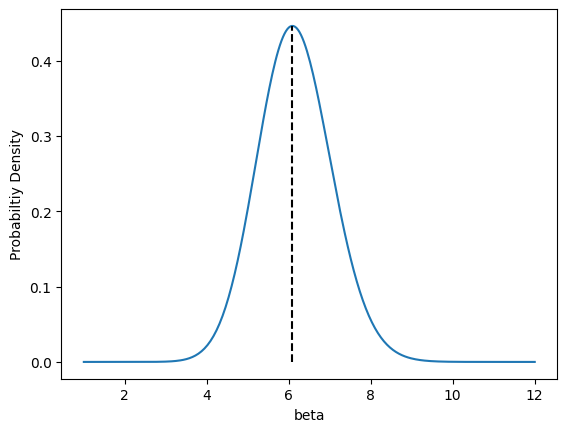

The most likely value for beta is:  6.077


In [7]:
def get_index(arr,value):
    return np.abs(arr-value).argmin() # Function from Lab 5 solutions

minB = 1
maxB = 12
betas = np.linspace(minB,maxB,numBetas) #our values of beta

y = post(betas,saveRate,goalScored,minB,maxB)

beta_estimate = betas[get_index(y, max(y))]
plt.plot(betas,y)
plt.vlines(beta_estimate, 0, max(y), linestyle = "dashed", color = "k")
plt.xlabel("beta")
plt.ylabel("Probabiltiy Density")
plt.show()

print("The most likely value for beta is: ",round(beta_estimate,3))

# MCMC One Variable

Now we need to define our functions that return a log value, and only take in one beta

In [8]:
# def log_prior(beta):
#     if -1.0 < beta < 14:
#         return 0.0 # the constant doesn't matter since MCMCs only care about *ratios* of probabilities
#     return -np.inf # log(0) = -inf

In [9]:
# #Define the likelihood function from wikipedia
# def log_likelihood(beta,Rate,Scored,log=True):
#     l = (sum(Scored*np.log(p(beta,Rate)) + (1-Scored)*np.log(1-p(beta,Rate))))

#     if(log):
#         return l
#     else:
#         return np.exp(l)

In [10]:
# def log_post(beta,Rate,Scored):
#     return log_prior(beta) + log_likelihood(beta,Rate,Scored)

In [11]:
import emcee

In [12]:
num_iter = 5000
ndim = 1 # number of parameters
nwalkers = ndim*18
initial_pos = np.array((4)) + 0.01 * np.random.randn(nwalkers, ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, functions.log_post, args=(saveRate,goalScored))
sampler.run_mcmc(initial_pos, num_iter, progress=True);

100%|███████████████████████████████████████| 5000/5000 [01:13<00:00, 67.93it/s]


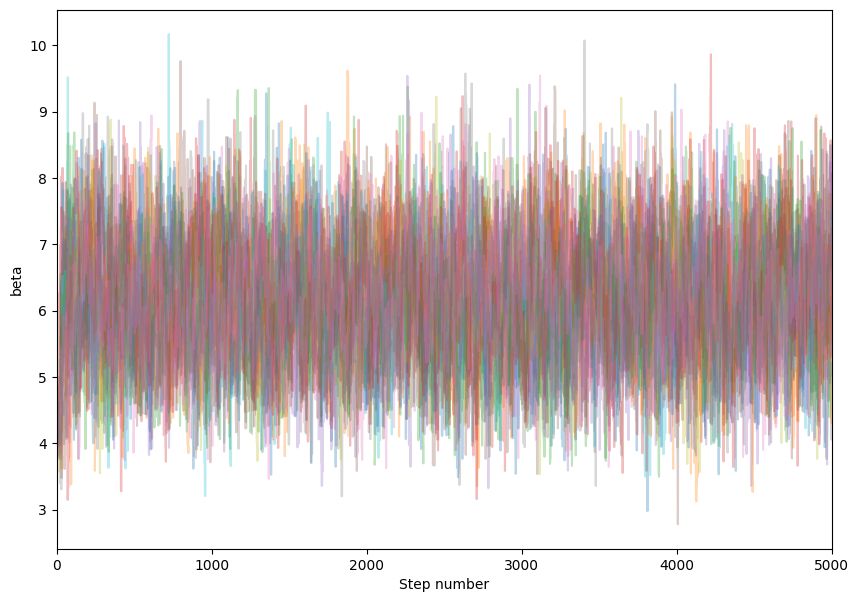

In [13]:
#Getting the trace plots
samples = sampler.get_chain()

f, axes = plt.subplots(1, figsize=(10, 7), sharex=True)
labels = ["beta"]
for i in range(ndim):
    ax = axes #Comment out if more than 1 subplot. Replace with line below
    #ax = axes[i] #Note if only one subplot, axes is not subscriptable
    ax.plot(samples[:, :, i], alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    #ax.yaxis.set_label_coords(-0.1, 0.5)

axes.set_xlabel("Step number"); #Comment out if more than 1 subplot. Replace with line below
#axes[-1].set_xlabel("Step number");


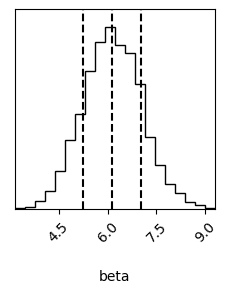

In [14]:
#Get the corner plots

#1) discarding the first 100 steps as burn-in steps, and 2) thinning the chain by taking only one out of every 15 steps
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
fig = corner.corner(flat_samples, labels=labels, quantiles=[0.16, 0.5, 0.84]);

Text(0, 0.5, '$P(Saving)$')

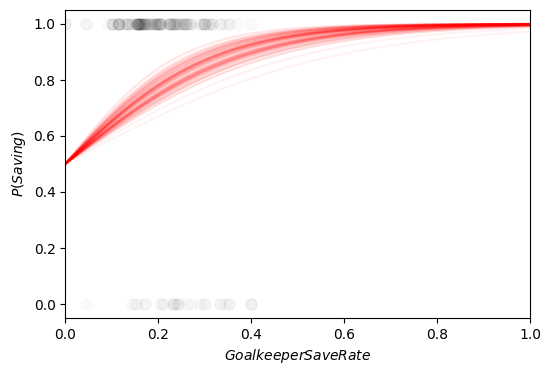

In [15]:
# Plotting our data against the betas

inds = np.random.randint(len(flat_samples), size=100)
#Plotting x0 against p(beta,x0). Therefore we want x0 to be an array replicating values of saveRate to plot
x0 = np.linspace(0, 1., len(saveRate))
f, ax = plt.subplots(figsize=(6,4))
#This loop plots a bunch of different lines for different values of beta
for ind in inds:
    sample = flat_samples[ind]
    ax.plot(x0, functions.p(sample[0], x0), alpha=0.05, color='red')
    
#Now plotting the actual data points to compare to the red lines
ax.errorbar(saveRate, goalScored, linestyle = 'None',capsize=4, marker ='o', color='black', ms=8, alpha=0.02)
ax.set_xlim(0, 1.)
ax.set_xlabel(r'$Goalkeeper Save Rate$')
ax.set_ylabel(r'$P(Saving)$')

Clearly our model of $P(Scoring) = \frac{1}{1+e^{-\beta (save rate)}}$ is incorrect. We do not have a constant beta to get a logistic regression. Lets try for $P(Scoring) = \frac{1}{1+e^{-\beta_1-\beta_2 (save rate)}}$

# MCMC Two Variables

In [16]:
# #Our new probability function with many betas.
# def pNew(beta, data):
#     '''
#     data: an array of data sets. The number of data sets defines the number of betas needed
#     '''
#     if len(beta)-1 != len(data):
#         print(beta)
#         raise ValueError("There is an incorrect balance of beta values and datasets.\nNote 'data' should be an array of datasets so that len(beta)-1 == len(data)")
    
#     exponent = -beta[0]
#     for i in range(len(data)):
#         exponent -= beta[i+1]*data[i]
#     return 1/(1+np.exp(exponent))

Lets plot the posteriors for each beta. We need to write new priors and likelihoods

In [17]:
#define a new prior that takes in two min and max values for each beta.
#input should be [[minB1,maxB1],[minB2,maxB2],...]
def priorTwo(MinMaxValues):
        
    if len(MinMaxValues) != 2:
        raise ValueError("There should be 2 pairs of min max values")
    
    #create an array with numBetas*(numBetas-1) values
    y = np.zeros((numBetas,numBetas-1))
    #We do the numBetas-i so that each beta dimension has a different length, leading to easier debugging
    #Note that we can't have too many betas compared to the size of numBetas
    
    y += 1/((MinMaxValues[0][0]-MinMaxValues[0][1])+(MinMaxValues[1][0]-MinMaxValues[1][1]))
        
    return np.array(y)

In [18]:
def likelihoodTwo(betas,Data,Scored,log=True):
    '''
    same as the likelihood function at first, but this time we have more betas. Betas is a numpy array of arrays of different betas
    '''
    if len(betas) != 2:
        raise ValueError("There should be 2 arrays of beta values")
    
    
    #Assign the two beta arrays to their own variable
    betas1 = betas[0]
    betas2 = betas[1]
    
    #create an array with numBetas*(numBetas-1) values
    l = np.zeros((numBetas,numBetas-1))
    #We do the numBetas-i so that each beta dimension has a different length, leading to easier debugging
    #Note that we can't have too many betas compared to the size of numBetas
    
    #Assign the values
    for i in range(len(betas1)):
        b1 = betas1[i]
        for j in range(len(betas2)):
            b2 = betas2[j]
            if(i%100 == 0 and j == 0):
                print(i)
            l[i][j] = (sum(Scored*np.log(functions.pNew([b1,b2],Data)) + (1-Scored)*np.log(1-functions.pNew([b1,b2],Data))))
            if(np.isnan(l[i][j]) or l[i][j] < -700):
                #If the answer is -infinity or really small, convert this value to something really small to avoid problems
                l[i][j] = -700 #An arbitrary number picked because np.exp(-700) can still be calculated, but it is really small

    if(log):
        return l
    else:
        return np.exp(l)

In [19]:
def normalize2d(data,dbeta1,dbeta2):
    return data/np.sum(np.sum(data)*dbeta1*dbeta2)  

def postTwo(betas,Data,Scored,MinMaxValues):
    '''
    same as the likelihood function at first, but this time we have more betas. Betas is a numpy array of arrays of different betas
    '''
    if len(betas) != 2:
        raise ValueError("There should be 2 arrays of beta values")
    
    #Calculate the posterior
    pd = priorTwo(MinMaxValues)*likelihoodTwo(betas,Data,Scored,False)
    
    #Now to normalise
    dbeta1 = (MinMaxValues[0][1]-MinMaxValues[0][0])/numBetas
    dbeta2 = (MinMaxValues[1][1]-MinMaxValues[1][0])/(numBetas-1)
    
    return normalize2d(pd,dbeta1,dbeta2)

/tmp/ipykernel_12551/3006053971.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  betas = np.array([betas1,betas2])


0
100
200


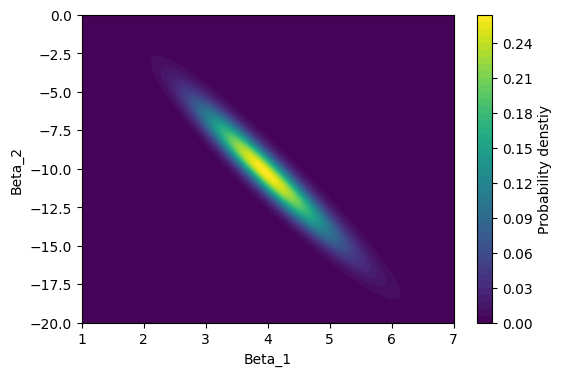

In [20]:
#initialise variables for posterior
data = np.array([saveRate]) #Recall data is an array of many data sets, just in this case we only are using one dataset
minB1 = 1
maxB1 = 7
minB2 = -20
maxB2 = 0
MinMaxValues = [[minB1,maxB1],[minB2,maxB2]]
betas1 = np.linspace(minB1,maxB1,numBetas)
betas2 = np.linspace(minB2,maxB2,numBetas-1)
betas = np.array([betas1,betas2])

#Run posterior
pd = postTwo(betas,data,goalScored,MinMaxValues)

#Plot posterior
fig1, ax = plt.subplots(figsize=(6,4))

cp = ax.contourf(betas1,betas2,pd.T,50)
cbar = plt.colorbar(cp)
cbar.ax.set_ylabel('Probability denstiy')
plt.xlabel("Beta_1")
plt.ylabel("Beta_2")
plt.show()


In [21]:
# def log_priorNew(beta):
#     for b in beta:
#         if -500 < b < 500:
#             continue
#         else:
#             return -np.inf # log(0) = -inf
#     return 0.0 # the constant doesn't matter since MCMCs only care about *ratios* of probabilities

In [22]:
# #Define the likelihood function from wikipedia
# def log_likelihoodNew(betas,data,Scored):
#     l = (sum(Scored*np.log(pNew(betas,data)) + (1-Scored)*np.log(1-pNew(betas,data))))
    
#     if(np.isnan(l)):
#         #If the answer is -infinity, convert nan to this value
#         l = -np.inf

#     return l

In [23]:
# def log_postNew(betas,Data,Scored):
#     return log_priorNew(betas) + log_likelihoodNew(betas,Data,Scored)

In [24]:
num_iter = 5000
ndim = 2 # number of parameters
nwalkers = ndim*18
initial_pos = np.array((2.5, -15)) + 0.01 * np.random.randn(nwalkers, ndim)

sampler2 = emcee.EnsembleSampler(nwalkers, ndim, functions.log_postNew, args=(np.array([saveRate]),goalScored))
sampler2.run_mcmc(initial_pos, num_iter, progress=True);

100%|██████████████████████████████████████| 5000/5000 [00:45<00:00, 109.03it/s]


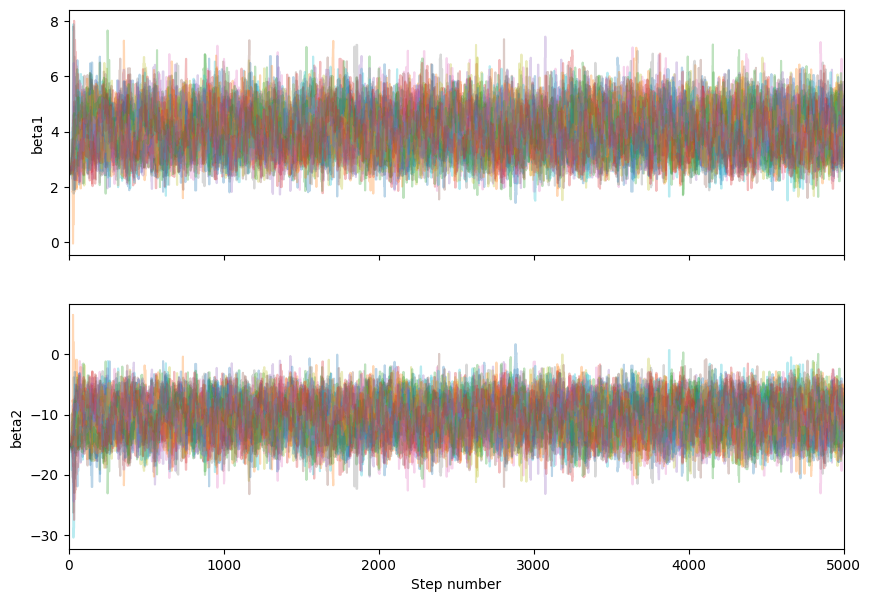

In [25]:
#Getting the trace plots
samples = sampler2.get_chain()

f, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
labels = ["beta1","beta2"]
for i in range(ndim):
    #ax = axes #Comment out if more than 1 subplot. Replace with line below
    ax = axes[i] #Note if only one subplot, axes is not subscriptable
    ax.plot(samples[:, :, i], alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    #ax.yaxis.set_label_coords(-0.1, 0.5)

#axes.set_xlabel("Step number"); #Comment out if more than 1 subplot. Replace with line below
axes[-1].set_xlabel("Step number");


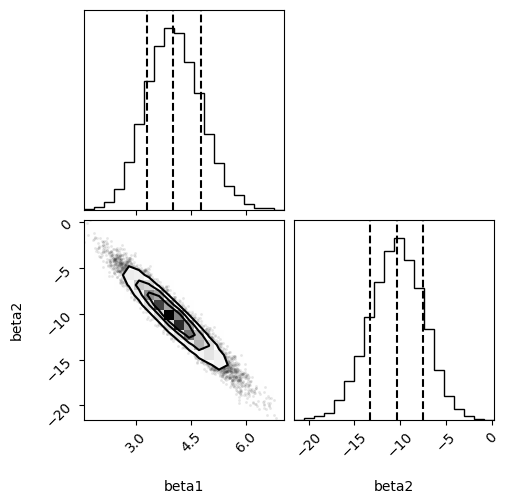

In [26]:
#Get the corner plots

#1) discarding the first 100 steps as burn-in steps, and 2) thinning the chain by taking only one out of every 15 steps
flat_samples = sampler2.get_chain(discard=100, thin=15, flat=True)
fig = corner.corner(flat_samples, labels=labels, quantiles=[0.16, 0.5, 0.84]);

Text(0, 0.5, '$P(Scoring)$')

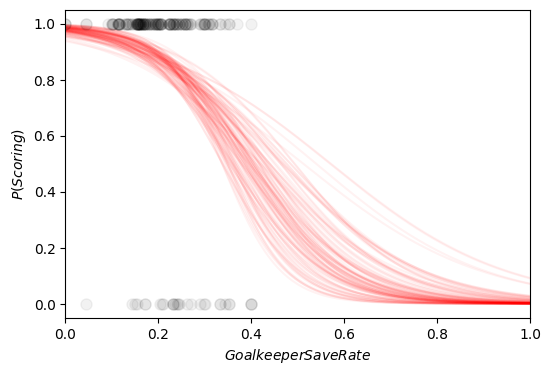

In [27]:
# Plotting our data against the betas

inds = np.random.randint(len(flat_samples), size=100)
#Plotting x0 against p(beta,x0). Therefore we want x0 to be an array replicating values of saveRate to plot
x0 = np.linspace(0, 1., len(saveRate))
f, ax = plt.subplots(figsize=(6,4))
#This loop plots a bunch of different lines for different values of beta
for ind in inds:
    sample = flat_samples[ind]
    ax.plot(x0, functions.pNew([sample[0],sample[1]], [x0]), alpha=0.05, color='red')
    
#Now plotting the actual data points to compare to the red lines
ax.errorbar(saveRate, goalScored, linestyle = 'None',capsize=4, alpha=0.05, marker ='o', color='black', ms=8)
ax.set_xlim(0, 1.)
ax.set_xlabel(r'$Goalkeeper Save Rate$')
ax.set_ylabel(r'$P(Scoring)$')

Much better! Lets try and add a second dataset to see how that affects our posterior. $P(Scoring) = \frac{1}{1+e^{-\beta_1-\beta_2 (save rate)-\beta_3 (Goal Difference)}}$.$\newline$
Unfortunately, three betas has now become too many betas to completely analyse and plot posteriors like above. Therefore we have to jump straight into MCMCs.

# MCMC Three Variables

In [28]:
num_iter = 5000
ndim = 3 # number of parameters
nwalkers = ndim*18
initial_pos = np.array((2.5, -15, 2)) + 0.01 * np.random.randn(nwalkers, ndim)

sampler3 = emcee.EnsembleSampler(nwalkers, ndim, functions.log_postNew, args=(np.array([saveRate,goalDiff]),goalScored))
sampler3.run_mcmc(initial_pos, num_iter, progress=True);

100%|███████████████████████████████████████| 5000/5000 [01:09<00:00, 72.38it/s]


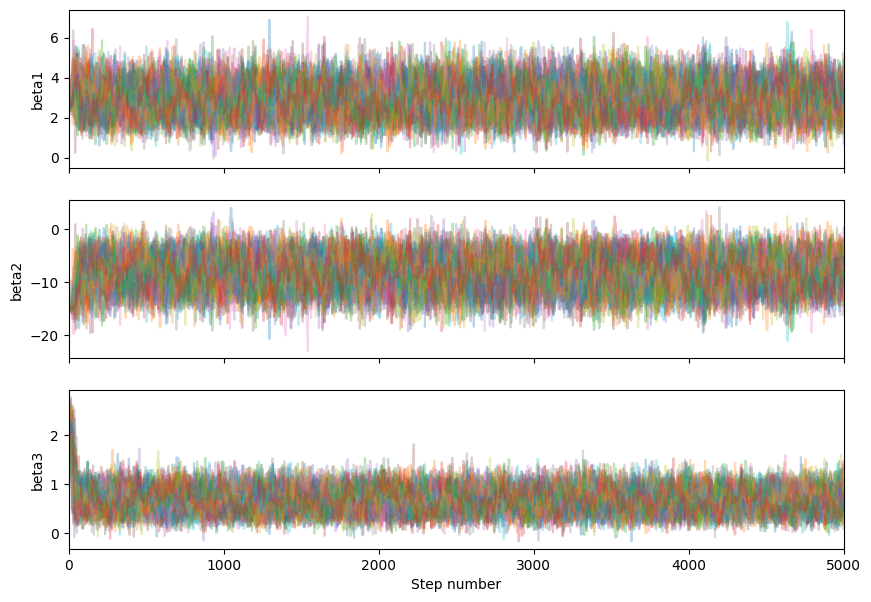

In [29]:
#Getting the trace plots
samples = sampler3.get_chain()

f, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
labels = ["beta1","beta2","beta3"]
for i in range(ndim):
    #ax = axes #Comment out if more than 1 subplot. Replace with line below
    ax = axes[i] #Note if only one subplot, axes is not subscriptable
    ax.plot(samples[:, :, i], alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    #ax.yaxis.set_label_coords(-0.1, 0.5)

#axes.set_xlabel("Step number"); #Comment out if more than 1 subplot. Replace with line below
axes[-1].set_xlabel("Step number");

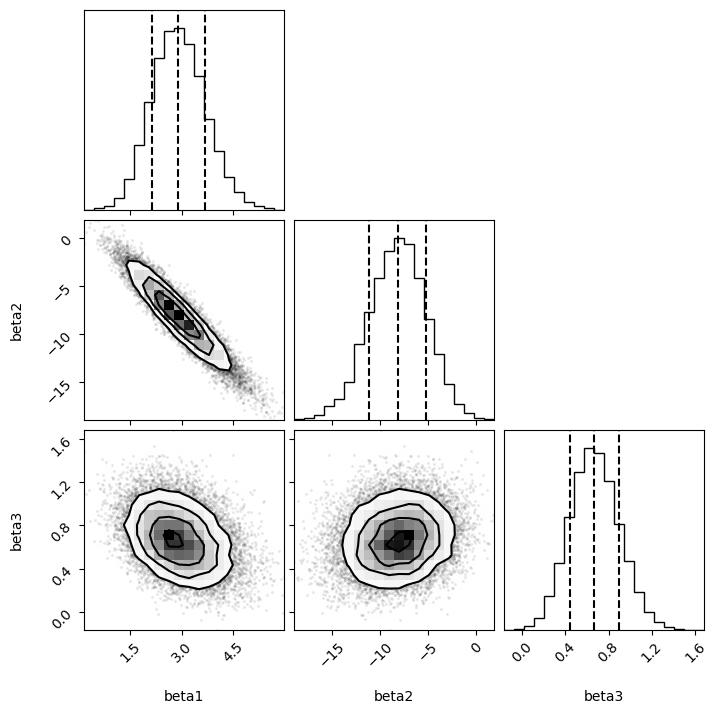

In [30]:
#Get the corner plots

#1) discarding the first 100 steps as burn-in steps, and 2) thinning the chain by taking only one out of every 15 steps
flat_samples = sampler3.get_chain(discard=100, thin=15, flat=True)
fig = corner.corner(flat_samples, labels=labels, quantiles=[0.16, 0.5, 0.84]);

Text(0, 0.5, '$P(Scoring)$')

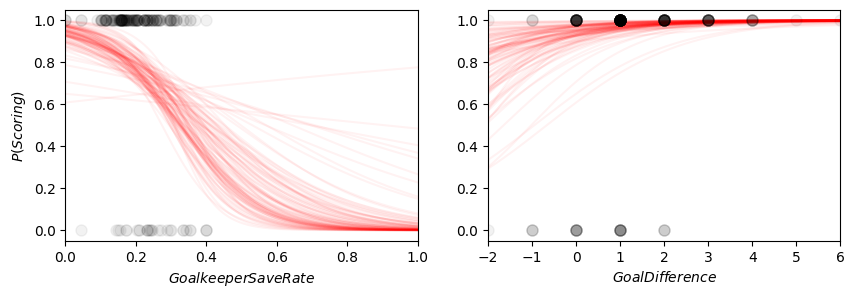

In [32]:
# Plotting our data against the Save Rate

inds = np.random.randint(len(flat_samples), size=100)
#Plotting x0 against p(beta,x0). Therefore we want x0 to be an array replicating values of saveRate to plot
x0 = np.linspace(0, 1., len(saveRate))
x1 = np.linspace(np.min(goalDiff), np.max(goalDiff), len(goalDiff))
f, ax = plt.subplots(1,2,figsize=(10,3))
#This loop plots a bunch of different lines for different values of beta
for ind in inds:
    sample = flat_samples[ind]
    ax[0].plot(x0, functions.pNew([sample[0],sample[1]], [x0]), alpha=0.05, color='red')
    ax[1].plot(x1, functions.pNew([sample[0],sample[2]], [x1]), alpha=0.05, color='red')
    
#Now plotting the actual data points to compare to the red lines
ax[0].errorbar(saveRate, goalScored, linestyle = 'None',capsize=4, alpha=0.05, marker ='o', color='black', ms=8)
ax[0].set_xlim(0, 1.)
ax[0].set_xlabel(r'$Goalkeeper Save Rate$')

#Now plotting the actual data points to compare to the red lines
ax[1].errorbar(goalDiff, goalScored, linestyle = 'None',capsize=4, alpha=0.05, marker ='o', color='black', ms=8)
ax[1].set_xlim(np.min(goalDiff), np.max(goalDiff))
ax[1].set_xlabel(r'$Goal Difference$')


ax[0].set_ylabel(r'$P(Scoring)$')

In [ ]:
#Now lets plot a 3d logistic regression
  
# importing required libraries
from random import randrange


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(saveRate, goalDiff, goalScored, color='red')
ax.set_xlabel("Goalkeeper Save Rate")
ax.set_ylabel("Goal Difference")
ax.set_zlabel("P(Scoring)")

for ind in inds:
    #ignore every two so the graph isn't too crowded
    if(randrange(3)==1):
        continue
    sample = flat_samples[ind]
    X, Y = np.meshgrid(x0,x1)
    Z = pNew([sample[0],sample[1],sample[2]], [X,Y])
    ax.plot_surface(X,Y,Z, alpha=0.01, color='red')


plt.show()

